In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keys import API_KEY

In [2]:
def get_energy_data_batches():
    url = "https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/"

    start_date = "2024-01-01T00"
    end_date = "2024-12-31T23"

    len_of_request = 5000
    offset = 0
    total_records = 0

    params = {
        "api_key": API_KEY,
        "frequency": "hourly",
        "data[0]": "value",
        "start": start_date,
        "end": end_date,
        "sort[0][column]": "period",
        "sort[0][direction]": "asc",
        "length": len_of_request
    }

    all_data = []

    print(f"Requesting monthly data from {start_date} to {end_date}...")
    print("Starting paginated data collection....")
    while True:
        params_copy = params.copy()
        params_copy['offset'] = offset
        print(f"Requesting {offset} to {len_of_request + offset - 1} rows...")
        response = requests.get(url, params=params_copy)
        if response.status_code != 200:
            print("Could not fetch the data from the source")
            print("Status code:", response.status_code)
            print("Response text:", response.text)  # <-- Add this
            break
        data = response.json()
        if 'response' in data and 'data' in data['response']:
            batch = pd.DataFrame(data['response']['data'])
            print(f"Retrieved {len(batch)} records.")
            if batch.empty:
                print("No data returned")
                break
            all_data.append(batch)
            batch_size = len(batch)
            total_records += batch_size
            print(f"Retrieved {batch_size} data and data amount totalled to {total_records}")
            if batch_size < len_of_request:
                print(f"Last batch is collected. Ending pagination.")
                break
            offset += batch_size
        else:
            print("No data returned for this batch.")
            break
    if batch.empty:
        print("No data was collected")
        return None

    energy_df = pd.concat(all_data, ignore_index=True)
    print(f"sucessfully collected {len(energy_df)} records")
    energy_df['period'] = pd.to_datetime(energy_df['period'])
    energy_df['value'] = pd.to_numeric(energy_df['value'], errors='coerce')

    return energy_df

energy_df = get_energy_data_batches()

if energy_df is not None and not energy_df.empty:
    print("\nData collection successful!")
    print(f"Dataset shape: {energy_df.shape}")
else:
    print("Data collection failed.")

Requesting monthly data from 2024-01-01T00 to 2024-12-31T23...
Starting paginated data collection....
Requesting 0 to 4999 rows...
Retrieved 5000 records.
Retrieved 5000 data and data amount totalled to 5000
Requesting 5000 to 9999 rows...
Retrieved 5000 records.
Retrieved 5000 data and data amount totalled to 10000
Requesting 10000 to 14999 rows...
Retrieved 5000 records.
Retrieved 5000 data and data amount totalled to 15000
Requesting 15000 to 19999 rows...
Retrieved 5000 records.
Retrieved 5000 data and data amount totalled to 20000
Requesting 20000 to 24999 rows...
Retrieved 5000 records.
Retrieved 5000 data and data amount totalled to 25000
Requesting 25000 to 29999 rows...
Retrieved 5000 records.
Retrieved 5000 data and data amount totalled to 30000
Requesting 30000 to 34999 rows...
Retrieved 5000 records.
Retrieved 5000 data and data amount totalled to 35000
Requesting 35000 to 39999 rows...
Retrieved 5000 records.
Retrieved 5000 data and data amount totalled to 40000
Requesting

In [3]:
## it is smarter to save the whole data after this api call since it is extremely long and takes around one and half hour to load
energy_df.to_csv("energy_data_new.csv", index=False)

In [15]:
energy_df = pd.read_csv("energy_data_new.csv", parse_dates=['period'])

In [16]:
energy_df

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2024-01-01,AECI,"Associated Electric Cooperative, Inc.",COL,Coal,2162.0,megawatthours
1,2024-01-01,AECI,"Associated Electric Cooperative, Inc.",NG,Natural Gas,984.0,megawatthours
2,2024-01-01,AECI,"Associated Electric Cooperative, Inc.",WND,Wind,244.0,megawatthours
3,2024-01-01,AVA,Avista Corporation,NG,Natural Gas,378.0,megawatthours
4,2024-01-01,AVA,Avista Corporation,OTH,Other,129.0,megawatthours
...,...,...,...,...,...,...,...
3427509,2024-12-31,WALC,Western Area Power Administration - Desert Sou...,WAT,Hydro,0.0,megawatthours
3427510,2024-12-31,WALC,Western Area Power Administration - Desert Sou...,WND,Wind,81.0,megawatthours
3427511,2024-12-31,WAUW,Western Area Power Administration - Upper Grea...,WAT,Hydro,69.0,megawatthours
3427512,2024-12-31,WWA,"NaturEner Wind Watch, LLC",WND,Wind,0.0,megawatthours


In [17]:
if energy_df is not None and not energy_df.empty:
    print("Hour distribution in energy_df AFTER dropna():")
    print(energy_df['period'].dt.hour.value_counts().sort_index())
else:
    print("energy_df is empty or None after dropna().")

Hour distribution in energy_df AFTER dropna():
period
0     143256
1     142842
2     142756
3     142763
4     142735
5     142683
6     142765
7     142771
8     142835
9     142880
10    142882
11    142894
12    142901
13    142891
14    142810
15    142795
16    142737
17    142726
18    142716
19    142762
20    142769
21    142759
22    142784
23    142802
Name: count, dtype: int64


In [18]:
energy_df.tail()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
3427509,2024-12-31,WALC,Western Area Power Administration - Desert Sou...,WAT,Hydro,0.0,megawatthours
3427510,2024-12-31,WALC,Western Area Power Administration - Desert Sou...,WND,Wind,81.0,megawatthours
3427511,2024-12-31,WAUW,Western Area Power Administration - Upper Grea...,WAT,Hydro,69.0,megawatthours
3427512,2024-12-31,WWA,"NaturEner Wind Watch, LLC",WND,Wind,0.0,megawatthours
3427513,2024-12-31,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",WAT,Hydro,123.0,megawatthours


In [20]:
energy_df.count()
val_count = energy_df['value'].count()
norm_count = energy_df['period'].count()
missing_vals = norm_count - val_count
missing_vals

3005

In [22]:
## only missing vals are the value in the data.
val_mean = energy_df["value"].mean()
energy_df['value'] = energy_df['value'].fillna(val_mean)
energy_df.count()

period             3427514
respondent         3427514
respondent-name    3427514
fueltype           3427514
type-name          3427514
value              3427514
value-units        3427514
dtype: int64

In [23]:
total_electric_used = energy_df['value'].sum()
total_electric_used

12483268161.855352

In [26]:
energy_df["hour"] = energy_df["period"].dt.hour

In [27]:
print("Distribution of hours in the original data:")
print(energy_df['period'].dt.hour.value_counts().sort_index())

# Check a few sample rows to see the actual timestamps
print("\nSample rows with period values:")
sample_rows = energy_df.sample(min(10, len(energy_df)))
print(sample_rows[['period', 'fueltype', 'value']])

# Check if all periods are on the same date(s)
print("\nUnique dates in the dataset:")
print(energy_df['period'].dt.date.value_counts().head())

# Examine how API calls were made
print("\nChecking your API call parameters:")
print("First few period_test tuples:")
# for i, (start, end) in enumerate(period_test[:5]):
#     print(f"{i}: {start} to {end}")

Distribution of hours in the original data:
period
0     143256
1     142842
2     142756
3     142763
4     142735
5     142683
6     142765
7     142771
8     142835
9     142880
10    142882
11    142894
12    142901
13    142891
14    142810
15    142795
16    142737
17    142726
18    142716
19    142762
20    142769
21    142759
22    142784
23    142802
Name: count, dtype: int64

Sample rows with period values:
                     period fueltype   value
2721324 2024-10-18 20:00:00      WND   180.0
1633852 2024-06-23 19:00:00      COL   639.0
1953729 2024-07-28 10:00:00       NG   371.0
2075009 2024-08-10 10:00:00      NUC  6960.0
3091480 2024-11-26 15:00:00      WND  1973.0
1315178 2024-05-20 16:00:00      NUC   116.0
1747093 2024-07-06 02:00:00      COL  2060.0
2730837 2024-10-19 21:00:00      WAT     0.0
307794  2024-02-02 20:00:00      OIL    59.0
2739045 2024-10-20 18:00:00       NG   996.0

Unique dates in the dataset:
period
2024-12-30    9889
2024-12-29    9835
2024-12-

In [28]:
data = energy_df.groupby(["hour", "fueltype"])["value"].sum()
data_table = data.unstack(fill_value=0)
data_table.head(100)

fueltype,BAT,COL,GEO,NG,NUC,OIL,OTH,PS,SNB,SUN,UES,UNK,WAT,WND
hour,,,,,,,,,,,,,,
0,366618.0,9.598552e+07,207.0,2.505868e+08,9.783960e+07,1.116723e+06,7.352985e+06,109317.0,546.0,3.088822e+07,-24360.0,0.0,4.093138e+07,5.414009e+07
1,319446.0,9.692966e+07,102.0,2.511909e+08,9.758205e+07,1.011683e+06,9.167407e+06,80535.0,3102.0,1.911531e+07,-21756.0,0.0,4.088594e+07,5.610309e+07
2,205896.0,9.546084e+07,105.0,2.467816e+08,9.755817e+07,8.996099e+05,1.083702e+07,37878.0,2097.0,1.011857e+07,-28569.0,0.0,3.953194e+07,5.921381e+07
3,170112.0,9.175203e+07,102.0,2.358746e+08,9.753125e+07,7.416718e+05,1.234054e+07,30570.0,1059.0,4.090970e+06,-41367.0,0.0,3.716574e+07,6.247330e+07
4,131025.0,8.667153e+07,90.0,2.218288e+08,9.749761e+07,5.174148e+05,1.294128e+07,29007.0,180.0,1.082597e+06,-54747.0,0.0,3.420998e+07,6.446409e+07
5,104115.0,8.134103e+07,105.0,2.099293e+08,9.742920e+07,4.763048e+05,1.169320e+07,27117.0,57.0,5.099638e+05,-59985.0,0.0,3.122872e+07,6.501250e+07
6,61173.0,7.710612e+07,105.0,1.990149e+08,9.755419e+07,4.544157e+05,1.034944e+07,3627.0,99.0,3.514088e+05,-76806.0,0.0,2.813598e+07,6.476670e+07
7,37626.0,7.366244e+07,108.0,1.916504e+08,9.753955e+07,4.443157e+05,8.555961e+06,2790.0,-6.0,2.274708e+05,-83385.0,0.0,2.541574e+07,6.386202e+07
8,24387.0,7.158906e+07,108.0,1.871344e+08,9.754524e+07,4.547658e+05,7.087029e+06,2460.0,-48.0,1.733838e+05,-93981.0,0.0,2.356255e+07,6.275975e+07


fueltype            BAT           COL         GEO            NG           NUC  \
count         24.000000  2.400000e+01   24.000000  2.400000e+01  2.400000e+01   
mean       88011.250000  8.397289e+07  175.250000  2.167361e+08  9.759211e+07   
std        97842.079771  8.062087e+06   52.492857  2.027497e+07  1.021292e+05   
min        12951.000000  7.089507e+07   90.000000  1.863062e+08  9.742920e+07   
25%        21262.500000  7.764439e+07  107.250000  2.033594e+08  9.753117e+07   
50%        38908.500000  8.439181e+07  207.000000  2.117583e+08  9.755618e+07   
75%       132250.500000  8.966501e+07  216.000000  2.325821e+08  9.766267e+07   
max       366618.000000  9.692966e+07  219.000000  2.511909e+08  9.783960e+07   

fueltype           OIL           OTH            PS          SNB           SUN  \
count     2.400000e+01  2.400000e+01      24.00000    24.000000  2.400000e+01   
mean      7.705402e+05  7.593129e+06   36911.75000   768.500000  2.566874e+07   
std       2.501642e+05  2.5

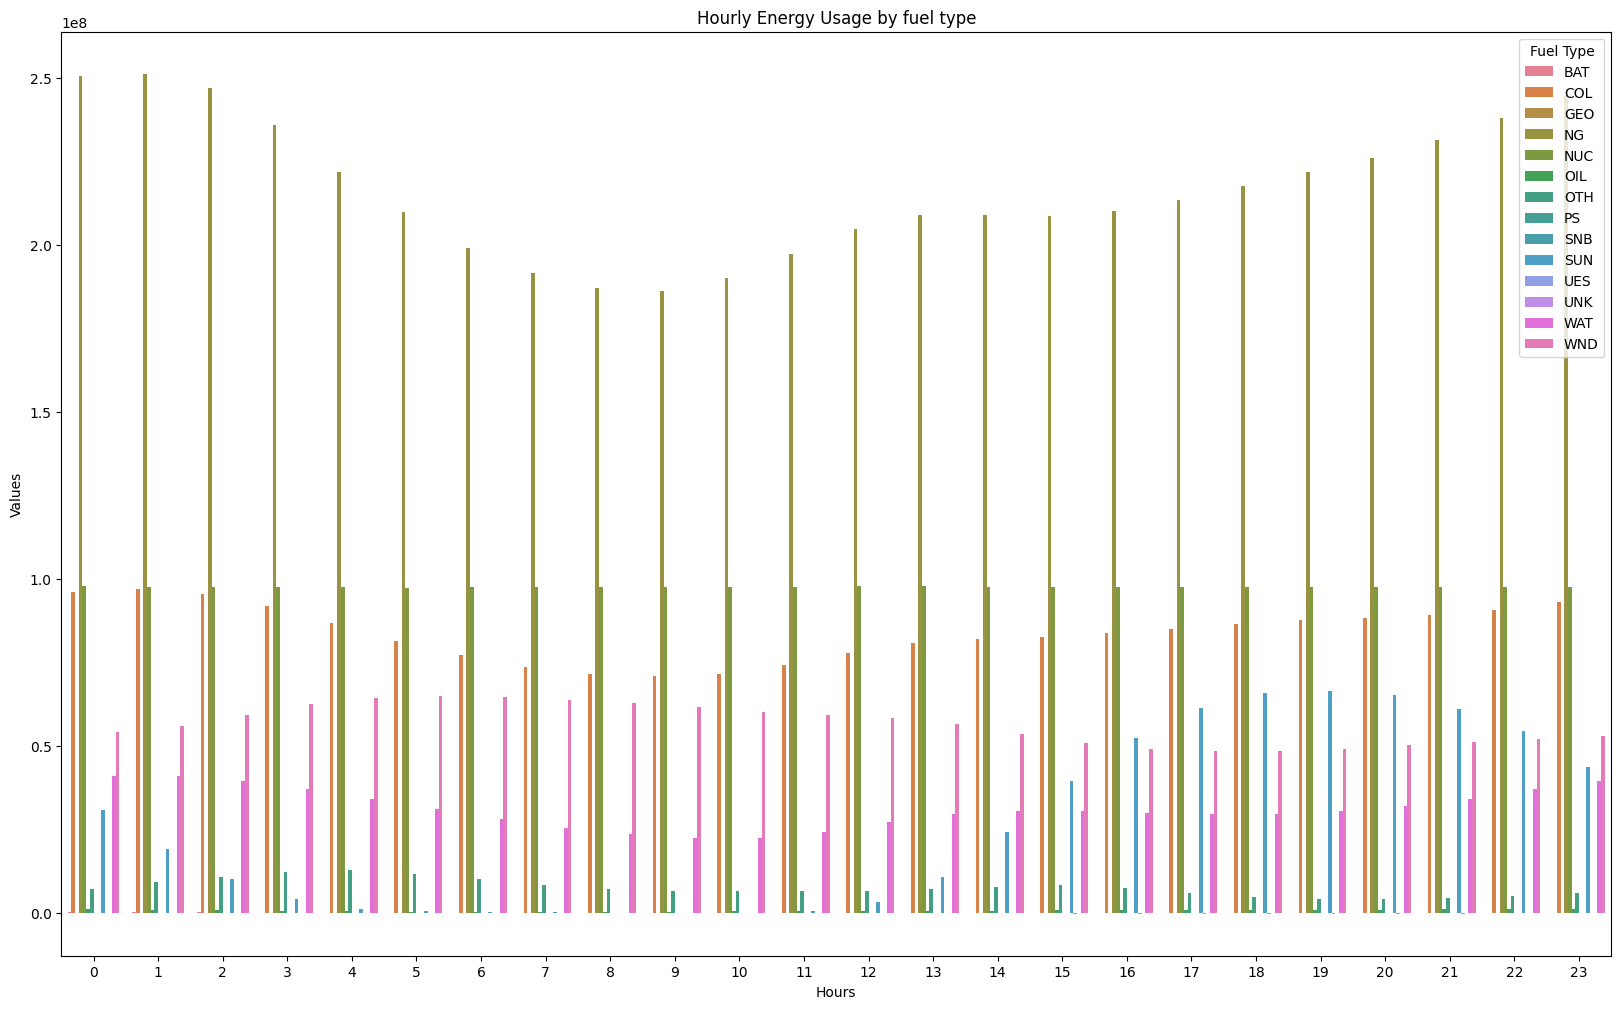

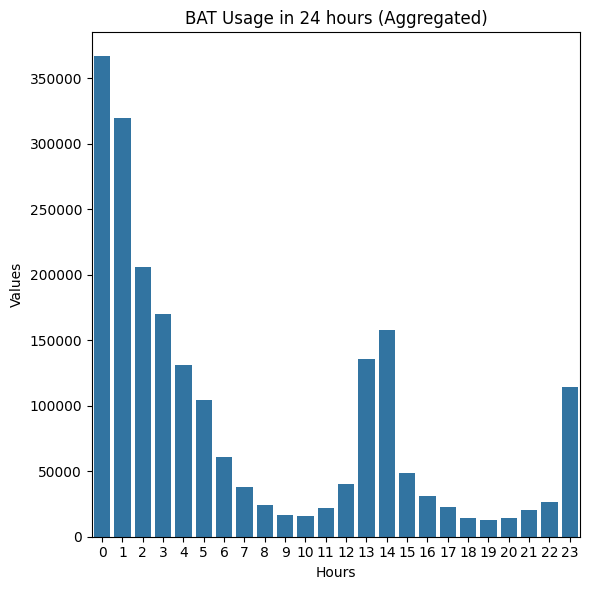

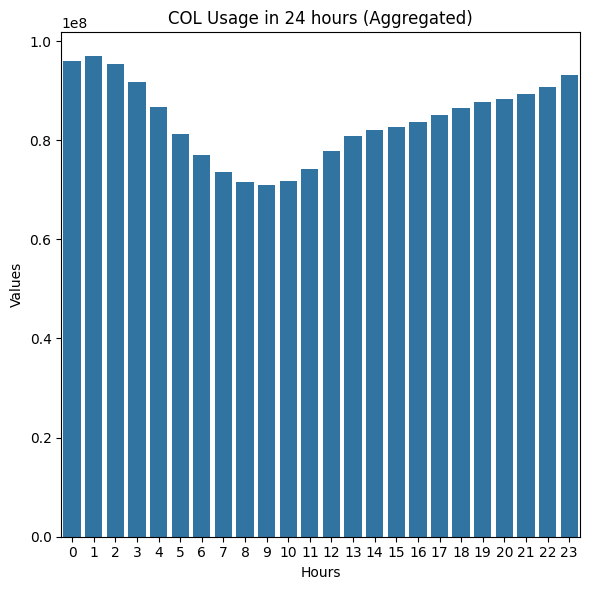

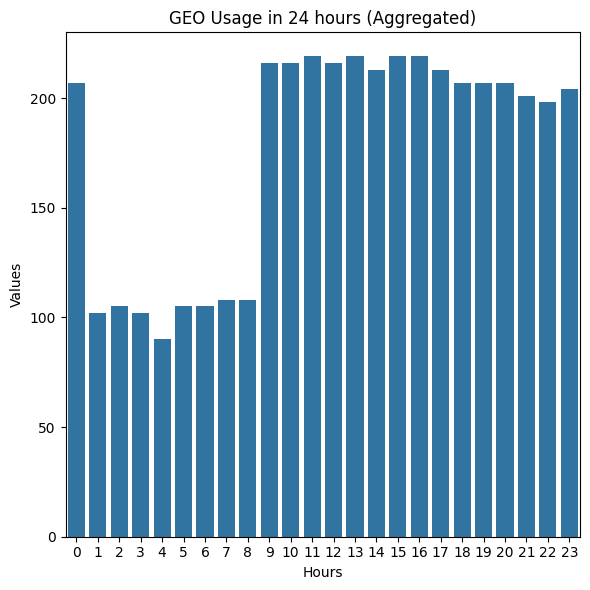

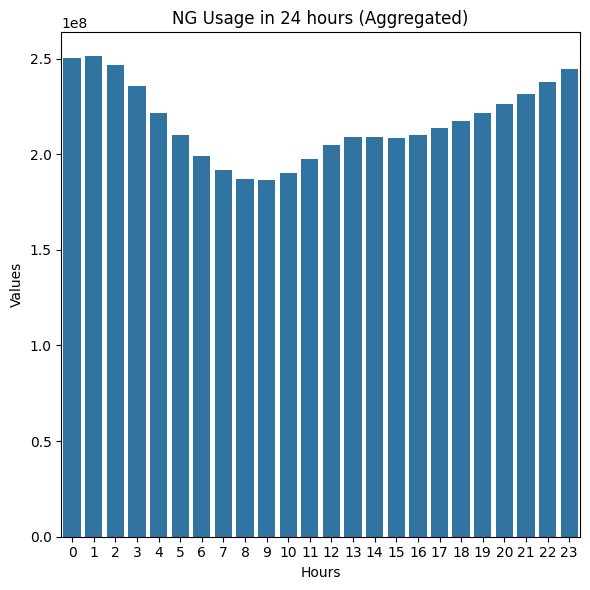

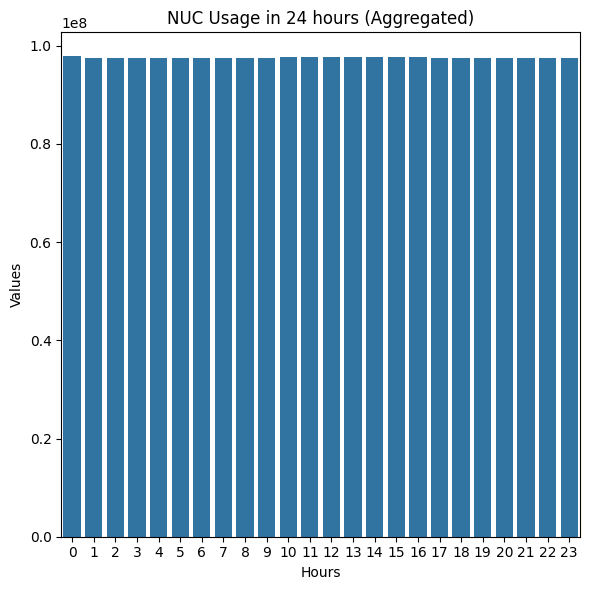

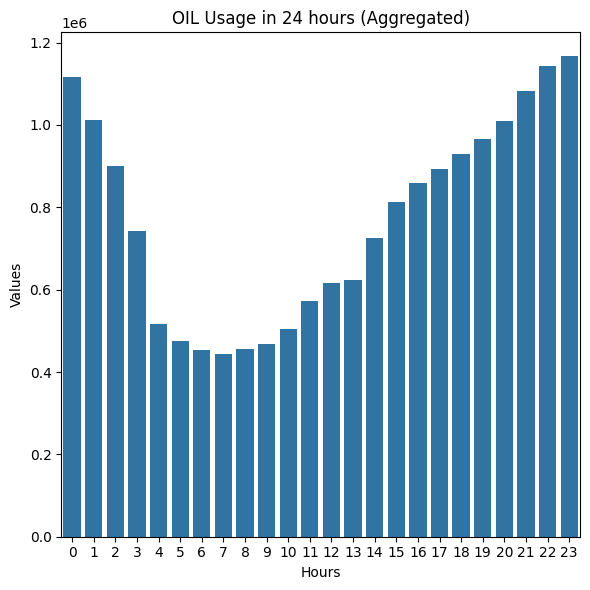

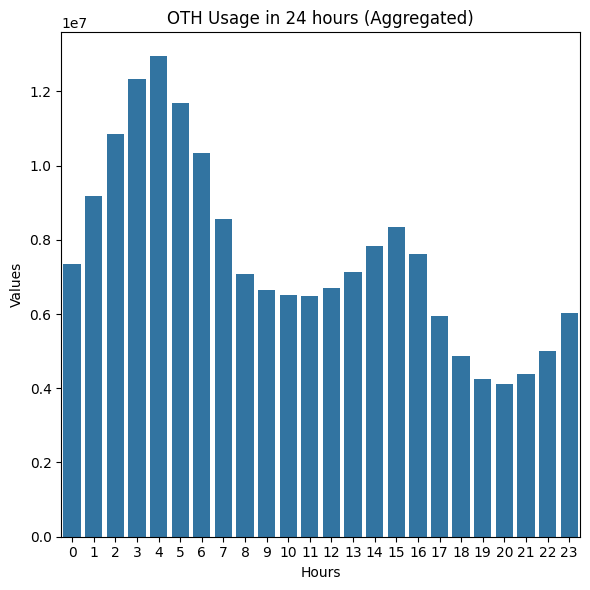

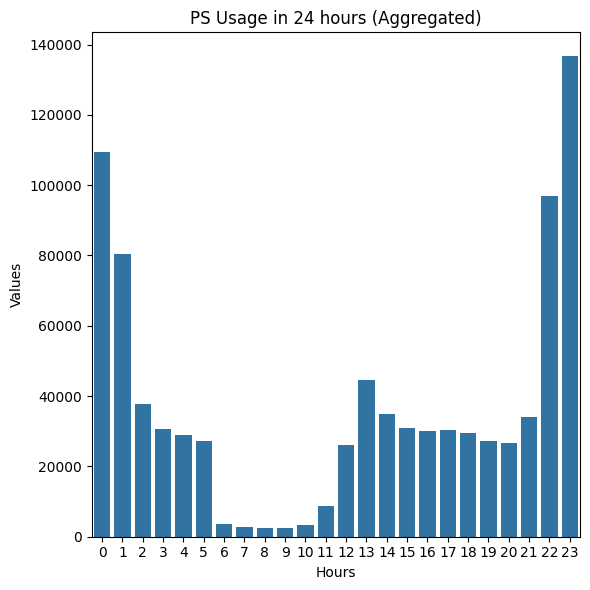

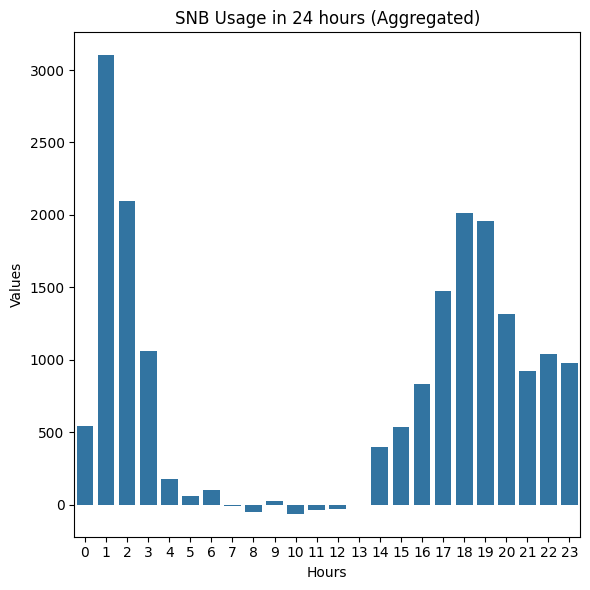

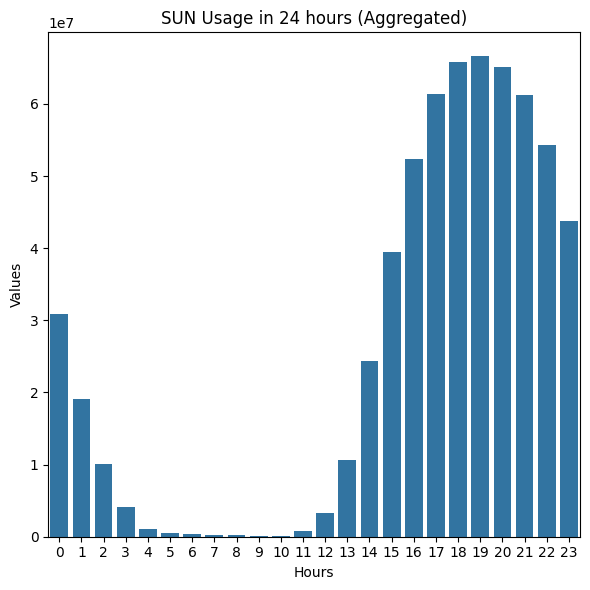

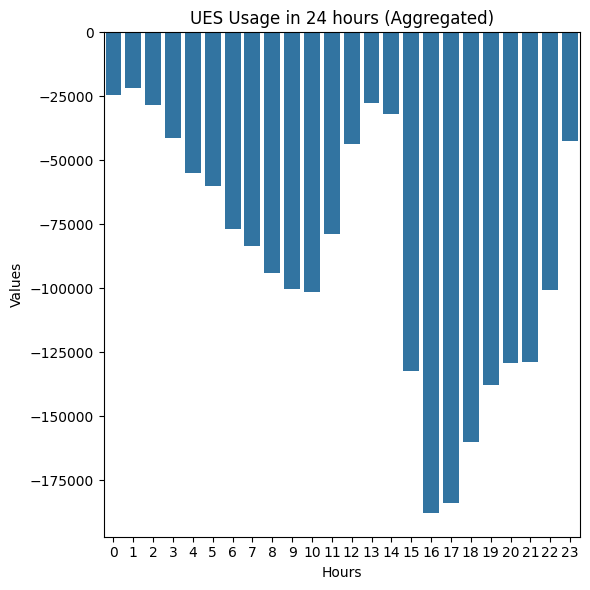

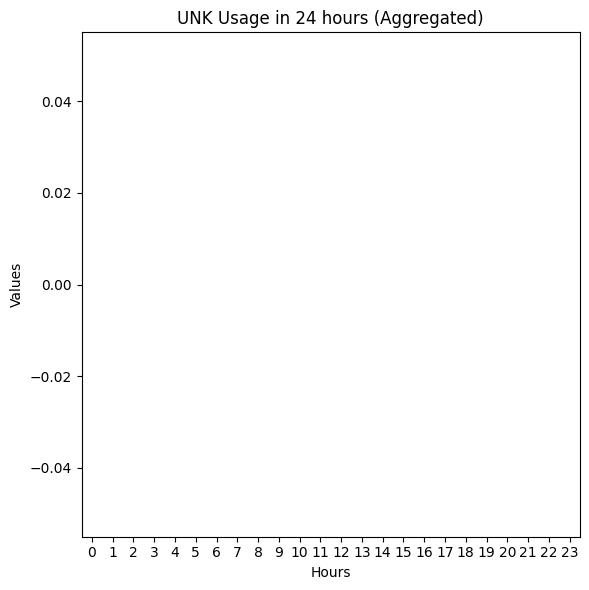

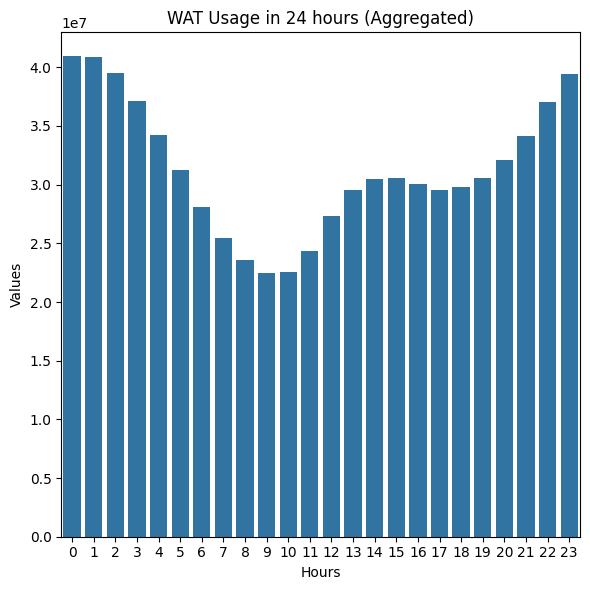

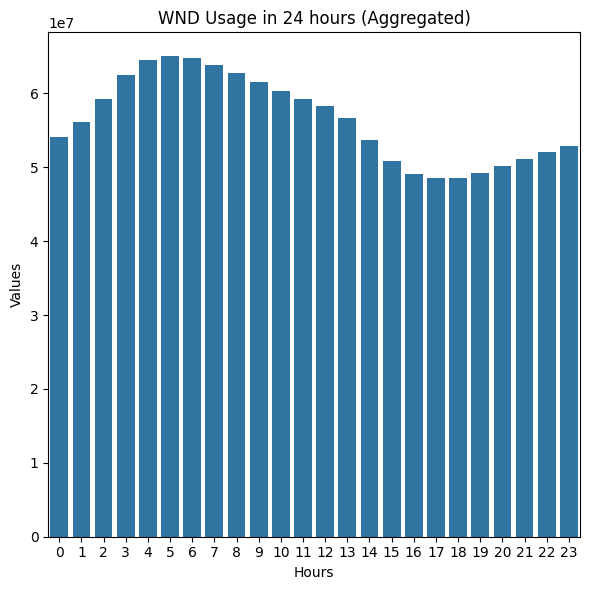

In [32]:
### Hourly analysis of the data 

# getting the overall statistics
print(data_table.describe())

stats = {}

for col in data_table.columns:
    stats[col] = {
        "mean": data_table[col].mean(),
        "median": data_table[col].median()
    }
print(stats)
stats_df = pd.DataFrame.from_dict(stats, orient='index')
print(stats_df)

# creating a long form table to efficiently display fuel usage by hour
data_table_long = data_table.reset_index()

df_long = data_table_long.melt(id_vars='hour', var_name='fueltype', value_name='value')

# visualazing the data
plt.figure(figsize=(20,12))
sns.barplot(data=df_long, x='hour', y='value', hue='fueltype')
plt.title("Hourly Energy Usage by fuel type")
plt.xlabel("Hours")
plt.ylabel("Values")
plt.legend(title="Fuel Type")
plt.show()

#checking the energy source usage one by one to get a deeper understanding of the issue

for col in data_table.columns:
    plt.figure(figsize=(6,6))
    sns.barplot(data=df_long[df_long['fueltype'] == col], x='hour', y='value')
    plt.title(f"{col} Usage in 24 hours (Aggregated)")
    plt.xlabel("Hours")
    plt.ylabel("Values")
    plt.tight_layout()
    plt.show()


In [17]:
df_long.head()

,hour,fueltype,value
0,0,BAT,366618.0
1,1,BAT,319446.0
2,2,BAT,205896.0
3,3,BAT,170112.0
4,4,BAT,131025.0


In [31]:
stats_df

,BAT mean,BAT median,COL mean,COL median,GEO mean,GEO median,NG mean,NG median,NUC mean,NUC median,...,SUN mean,SUN median,UES mean,UES median,UNK mean,UNK median,WAT mean,WAT median,WND mean,WND median
0,88011.25,38908.5,8.397289e+07,8.439181e+07,175.25,207.0,2.167361e+08,2.117583e+08,9.759211e+07,9.755618e+07,...,2.566874e+07,1.488844e+07,-86270.375,-81136.5,0.0,0.0,3.129876e+07,3.052128e+07,5.646428e+07,5.638895e+07
